In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS
import unidecode
from textblob import TextBlob
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Data Understanding

In [2]:
train_df = pd.read_csv(
    "dataset/train.csv",
    header=None
)
test_df = pd.read_csv(
    "dataset/test.csv",
    header=None
)

train_df.columns = test_df.columns = ["rating", "review"]

In [3]:
train_df.head()

,rating,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [4]:
test_df.head()

,rating,review
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [5]:
train_df["rating"].value_counts()

1    280000
2    280000
Name: rating, dtype: int64

#### There are total 560,000 records in Training dataset.

In [6]:
test_df["rating"].value_counts()

2    19000
1    19000
Name: rating, dtype: int64

#### There are total 38,000 records in Training dataset.

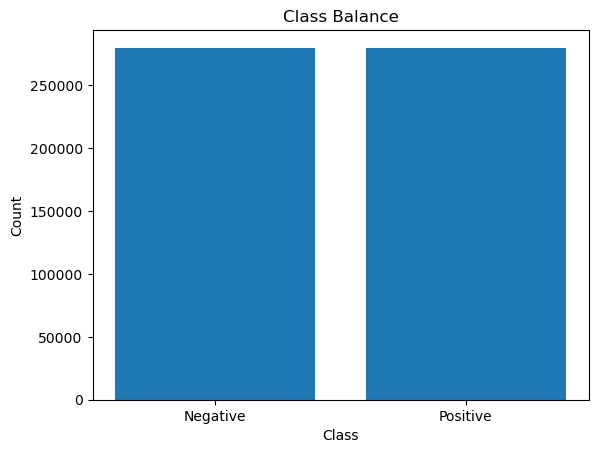

In [7]:
unique, count = np.unique(train_df.rating, return_counts=True)
plt.bar(["Negative" if i == 1 else "Positive" for i in unique], count)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

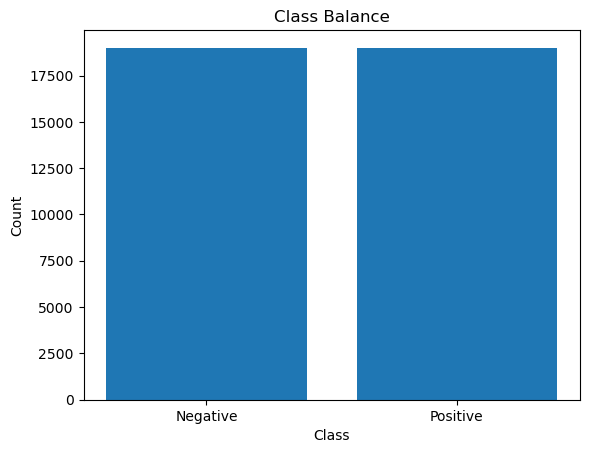

In [8]:
unique, count = np.unique(test_df.rating, return_counts=True)
plt.bar(["Negative" if i == 1 else "Positive" for i in unique], count)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

## Both above bar plots show that target variable 'rating' is well balanced with equal number of records for both positive and negative sentiments.

# No actions required to balance dataset to build better model.

In [9]:
def find_special_chars(sentence):
    """Function to find if a sentence contains any special chars.
    Returns 0 if no special chars are found and 1 if found.
    """
    spec_regex = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    if(spec_regex.search(sentence) == None):
        return 0
    return 1
    
special_count = 0
for review in train_df.review:
    special_count += find_special_chars(review)

print(f"Reviews with special characters: {special_count} out of {len(train_df.review)}")

Reviews with special characters: 410217 out of 560000


In [10]:
def contains_shorthand(sentence):
    """Function to find if a sentence contain any shorthand
    Return 1 if yes else no.
    """
    if "'" in sentence:
        return 1
    return 0
    
shorthand_count = 0
for review in train_df.review:
    shorthand_count += contains_shorthand(review)

print(f"Reviews with shorthands: {shorthand_count} out of {len(train_df.review)}")

Reviews with shorthands: 394763 out of 560000


In [11]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

def contains_stopwords(sentence, stopwords_list):
    """Function to find if a sentence contain any stopwords
    Return 1 if yes else 0.
    """
    for word in sentence.split(" "):
        if word.strip() in stopwords_list:
            return 1
    return 0

stopwords_count = 0
for review in train_df.review:
    stopwords_count += contains_stopwords(review, stopwords_list)

print(f"Reviews with stopwords: {stopwords_count} out of {len(train_df.review)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ddurgoji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reviews with stopwords: 556099 out of 560000


In [12]:
def contains_link(sentence):
    """Function to find if a sentence contain any http(s) link(s)
    Returns 1 if yes else no.
    """
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(url_regex, sentence)
    if url:
        return 1
    return 0

links_count = 0
for review in train_df.review:
    links_count += contains_link(review)

print(f"Reviews with http(s) links: {links_count} out of {len(train_df.review)}")

Reviews with http(s) links: 2501 out of 560000


# Data preparation

In [13]:
train_df_fixed = train_df.copy(deep=True)

def case_convert():
    """Function to convert all letters to lower case
    """
    train_df_fixed.review = [i.lower() for i in train_df_fixed.review.values]

def remove_special_chars():
    """Function to remove special characters
    """
    train_df_fixed.review =  [re.sub(r"[^a-zA-Z]"," ",text) for text in train_df_fixed.review.values]
    
def remove_stopwords():
    """Function to remove stop words
    """
    reviews = []
    stopwords_list = stopwords.words('english')
    for item in train_df_fixed.review.values:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        reviews.append(string)
    train_df_fixed.review = reviews
        
def remove_links():
    """Function to remove http(s)links
    """
    reviews = []
    for review in train_df_fixed.review.values:
        remove_https = re.sub(r'http\S+', '', review)
        remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        reviews.append(remove_com)
    train_df_fixed.review = reviews

def remove_accents():
    """Function to remove accents from reviews
    """
    train_df_fixed.review = [unidecode.unidecode(review) for review in train_df_fixed.review.values]

def normalize_spaces():
    """Function to normalize spaces
    """
    train_df_fixed.review = [re.sub(r"\s+"," ", review) for review in train_df_fixed.review.values]
    
def remove_shorthands():
    """Function to remove short hands in reviews
    """
    CONTRACTION_MAP = {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
    reviews = []
    for review in train_df_fixed.review.values:
        string = ""
        for word in review.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        reviews.append(string.strip())
    train_df_fixed.review = reviews

In [14]:
case_convert()
remove_links()
remove_shorthands()
remove_accents()
remove_special_chars()
remove_stopwords()
normalize_spaces()

In [15]:
train_df_fixed

,rating,review
0,1,unfortunately frustration dr goldberg patient...
1,2,going dr goldberg years think one st patients...
2,1,know dr goldberg like moving arizona let tell...
3,1,writing review give heads see doctor office s...
4,2,food great best thing wings wings simply fant...
...,...,...
559995,2,ryan good everyone yelp claimed courteous kno...
559996,2,professional nfriendly non time affordable nw...
559997,1,phone calls always go voicemail messages retu...
559998,1,looks like good reviews gone head place jason...


In [16]:
links_count = 0
for review in train_df_fixed.review:
    links_count += contains_link(review)

print(f"Reviews with http(s) links: {links_count} out of {len(train_df_fixed.review)}")

stopwords_count = 0
for review in train_df_fixed.review:
    stopwords_count += contains_stopwords(review, stopwords_list)

print(f"Reviews with stopwords: {stopwords_count} out of {len(train_df_fixed.review)}")

shorthand_count = 0
for review in train_df_fixed.review:
    shorthand_count += contains_shorthand(review)

print(f"Reviews with shorthands: {shorthand_count} out of {len(train_df_fixed.review)}")

special_count = 0
for review in train_df_fixed.review:
    special_count += find_special_chars(review)

print(f"Reviews with special characters: {special_count} out of {len(train_df_fixed.review)}")

Reviews with http(s) links: 0 out of 560000
Reviews with stopwords: 0 out of 560000
Reviews with shorthands: 0 out of 560000
Reviews with special characters: 0 out of 560000


## All special characters, Stop words, Short hands, HTTP(S) links etc. are removed

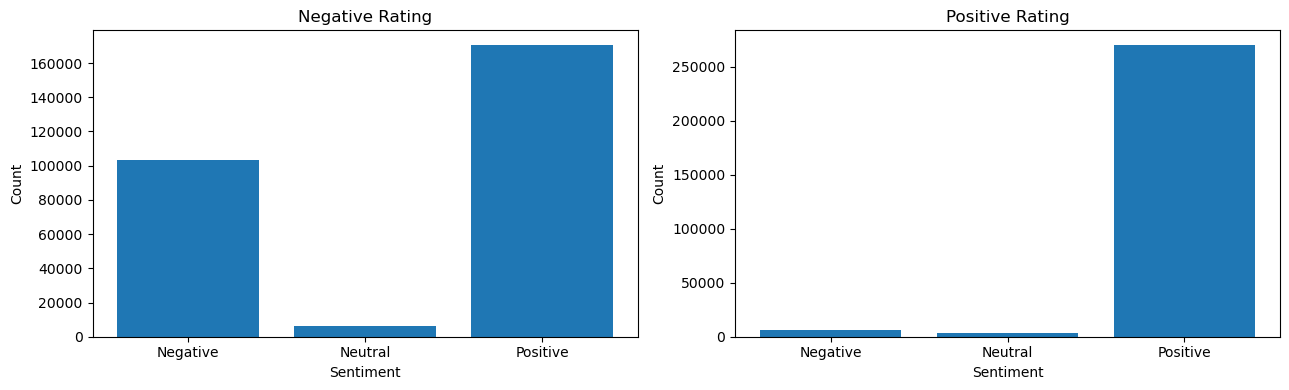

In [17]:
sentiment = []
for text in train_df_fixed.review.values:
    polarity = TextBlob(text).sentiment.polarity
    if polarity < 0:
        sentiment.append("Negative")
    elif polarity == 0:
        sentiment.append("Neutral")
    else:
        sentiment.append("Positive")
train_df_fixed["sentiment"] = sentiment
del sentiment

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
un, count = np.unique(train_df_fixed[train_df_fixed.rating == 1].sentiment, return_counts=True)
plt.bar(un, count)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Negative Rating")
plt.subplot(1,2,2)
un, count = np.unique(train_df_fixed[train_df_fixed.rating == 2].sentiment,return_counts=True)
plt.bar(un, count)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Positive Rating")
plt.tight_layout()

* First plot shows that Negative rating reviews have majority of positive sentiment than negative.
* Second plot shows that Positive rating reviews have majority positive sentiment reviews.
* Neutral sentiment reviews are very low in both plots

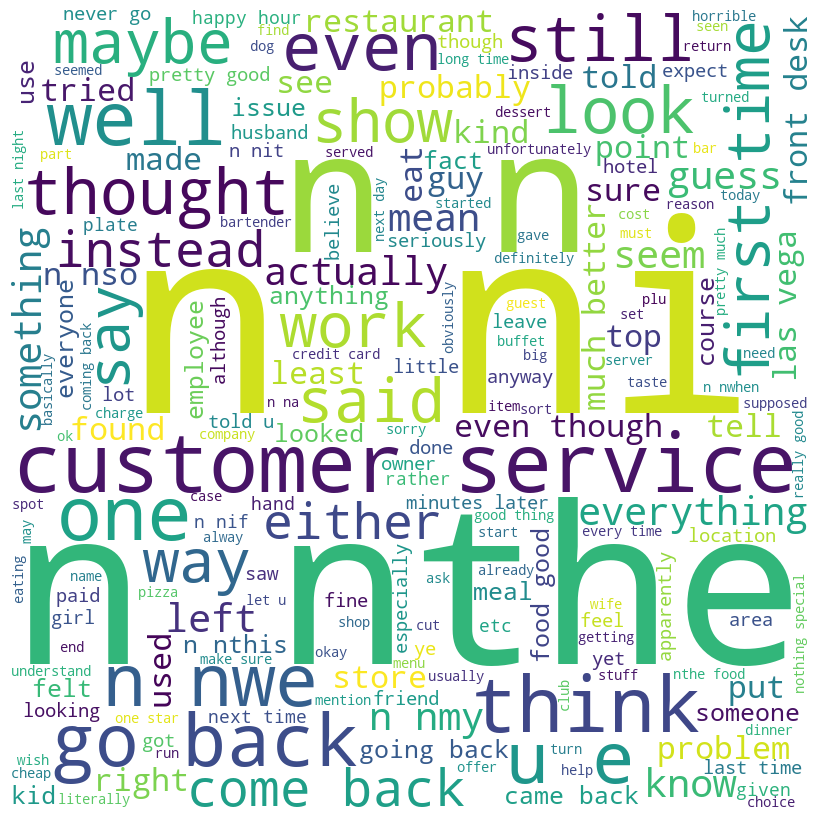

In [18]:
string = ""
for i in train_df_fixed[train_df_fixed.rating == 1].review:
    string = string + " " + i.strip()
    
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color ='black',
    stopwords = set(STOPWORDS),
    min_font_size = 10
).generate(string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
del string

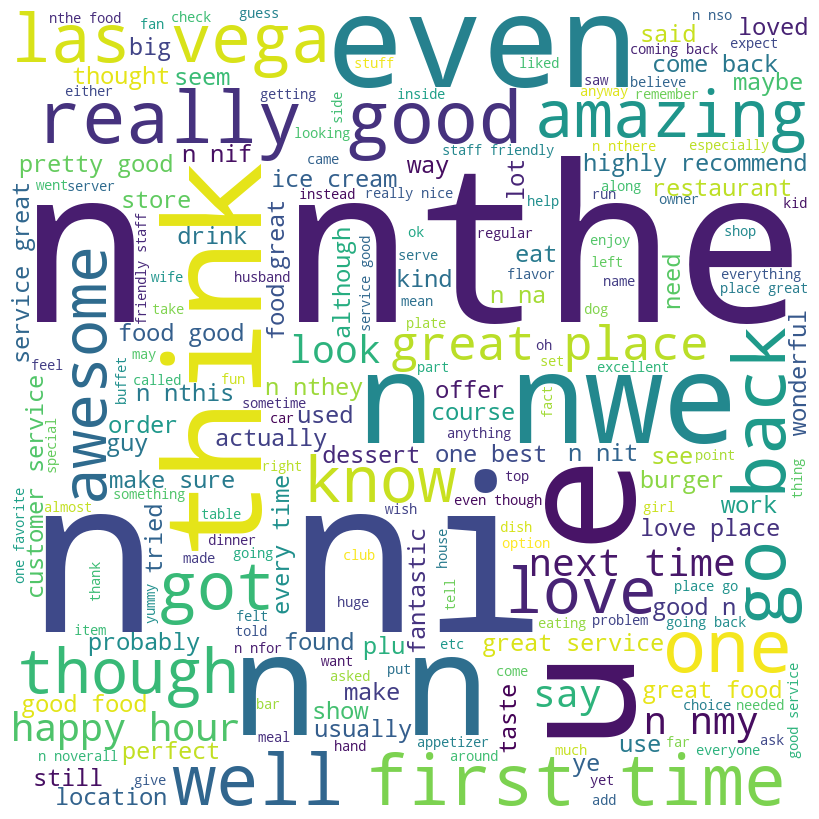

In [19]:
string = ""
for i in train_df_fixed[train_df_fixed.rating == 2].review:
    string = string + " " + i.strip()
    
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color ='white',
    stopwords = set(STOPWORDS),
    min_font_size = 10
).generate(string)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
del string

<Axes: xlabel='rating', ylabel='text_length'>

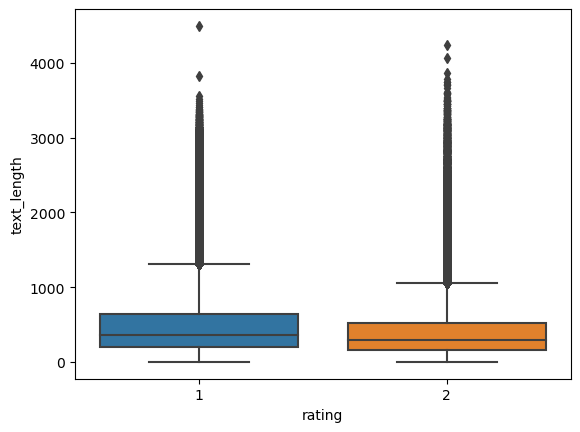

In [20]:
train_df_fixed['text_length'] = train_df_fixed['review'].apply(len)
sns.boxplot(x='rating', y='text_length', data=train_df_fixed)

## Above plot shows that for both positive and negative classes review text length is almost similar. 

# Modelling

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df_fixed.review.values, 
    train_df_fixed.rating.values,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [33]:
pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('mnb', MultinomialNB())
    ]
)

parameters = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
    'mnb__alpha': [0.0, 0.5, 1.0],
    'mnb__fit_prior': [True, False],
    'mnb__force_alpha': [True, False]
}

mnb_grid = RandomizedSearchCV(
    pipeline,
    parameters,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    verbose=10,
    n_iter=50
)
mnb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/5; 1/50] END mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.872 total time=   9.4s
[CV 2/5; 1/50] START mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/5; 1/50] END mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.872 total t

[CV 3/5; 4/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.776 total time=  32.7s
[CV 4/5; 4/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/5; 4/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.780 total time=  32.8s
[CV 5/5; 4/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/5; 4/50] END mnb__alpha=1.0, mnb__fit_pr

[CV 1/5; 8/50] END mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=100, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.759 total time=  38.1s
[CV 2/5; 8/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=100, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/5; 8/50] END mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=100, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.757 total time=  39.9s
[CV 3/5; 8/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=100, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/5; 8/50] END mnb__alpha=0.5, mnb__fit_prior=

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 1/5; 11/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.820 total time=  31.6s
[CV 2/5; 11/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 2/5; 11/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.821 total time=  31.6s
[CV 3/5; 11/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 3/5; 11/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.820 total time=  31.8s
[CV 4/5; 11/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 4/5; 11/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.822 total time=  31.6s
[CV 5/5; 11/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 5/5; 11/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.821 total time=  31.7s
[CV 1/5; 12/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/5; 12/50] END mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.841 total time=   9.2s
[CV 2/5; 12/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/5; 12/50] END mnb__alpha=0.5, mnb__fit_p

[CV 3/5; 15/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.831 total time=   9.2s
[CV 4/5; 15/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/5; 15/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.835 total time=   9.1s
[CV 5/5; 15/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/5; 15/50] END mnb__alpha=1.0, mn

[CV 1/5; 19/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.800 total time=   8.8s
[CV 2/5; 19/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/5; 19/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.799 total time=   8.9s
[CV 3/5; 19/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/5; 19/50] END mnb__alpha=1.0, mnb__fit_p

[CV 4/5; 22/50] END mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.747 total time=  30.9s
[CV 5/5; 22/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/5; 22/50] END mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.748 total time=  31.4s
[CV 1/5; 23/50] START mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/5; 23/50] END mnb__alpha=1.0, mnb__f

[CV 2/5; 26/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.648 total time=  32.7s
[CV 3/5; 26/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/5; 26/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.647 total time=  31.9s
[CV 4/5; 26/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/5; 26/50] END mnb__alpha=1.0, mnb__fit_prior

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 1/5; 27/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.649 total time=  32.2s
[CV 2/5; 27/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 2/5; 27/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.648 total time=  31.8s
[CV 3/5; 27/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 3/5; 27/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.647 total time=  31.7s
[CV 4/5; 27/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 4/5; 27/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.649 total time=  31.7s
[CV 5/5; 27/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 5/5; 27/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=100, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.648 total time=  31.7s
[CV 1/5; 28/50] START mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 1/5; 28/50] END mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.864 total time=   9.3s
[CV 2/5; 28/50] START mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 2/5; 28/50] END mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.865 total time=   9.2s
[CV 3/5; 28/50] START mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 3/5; 28/50] END mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.863 total time=   9.2s
[CV 4/5; 28/50] START mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 4/5; 28/50] END mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.866 total time=   9.2s
[CV 5/5; 28/50] START mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 5/5; 28/50] END mnb__alpha=0.0, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.865 total time=   9.2s
[CV 1/5; 29/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/5; 29/50] END mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.746 total time=  32.7s
[CV 2/5; 29/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/5; 29/50] END mnb__alpha=0.5, mnb__fi

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 1/5; 32/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.785 total time=   9.1s
[CV 2/5; 32/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 2/5; 32/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.786 total time=   9.1s
[CV 3/5; 32/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 3/5; 32/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.786 total time=   9.1s
[CV 4/5; 32/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 4/5; 32/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.789 total time=   9.0s
[CV 5/5; 32/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 5/5; 32/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.788 total time=   9.0s
[CV 1/5; 33/50] START mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/5; 33/50] END mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.864 total time=   9.3s
[CV 2/5; 33/50] START mnb__alpha=0.5, mnb__fit_prior=False, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/5; 33/50] END mnb__alpha=0.

[CV 3/5; 36/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.877 total time=   9.5s
[CV 4/5; 36/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/5; 36/50] END mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.881 total time=   9.4s
[CV 5/5; 36/50] START mnb__alpha=1.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/5; 36/50] END mnb__alpha=1.0, mnb__fit_prior

[CV 1/5; 40/50] END mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.863 total time=   9.8s
[CV 2/5; 40/50] START mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/5; 40/50] END mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.864 total time=   9.4s
[CV 3/5; 40/50] START mnb__alpha=1.0, mnb__fit_prior=False, mnb__force_alpha=True, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/5; 40/50] END mnb__alpha=1.0, mn

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 1/5; 43/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.885 total time=   9.2s
[CV 2/5; 43/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 2/5; 43/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.885 total time=   9.2s
[CV 3/5; 43/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 3/5; 43/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.882 total time=   9.2s
[CV 4/5; 43/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 4/5; 43/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.887 total time=   9.2s
[CV 5/5; 43/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 5/5; 43/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.884 total time=   9.2s
[CV 1/5; 44/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=3000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/5; 44/50] END mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=3000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.878 total time=  40.2s
[CV 2/5; 44/50] START mnb__alpha=0.5, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=3000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/5; 44/50] END mnb__alpha=0.5, mnb__fit_pr

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 1/5; 47/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.884 total time=  40.1s
[CV 2/5; 47/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 2/5; 47/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.885 total time=  41.2s
[CV 3/5; 47/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 3/5; 47/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.883 total time=  41.0s
[CV 4/5; 47/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 4/5; 47/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.886 total time=  40.1s
[CV 5/5; 47/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 5/5; 47/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.886 total time=  40.6s
[CV 1/5; 48/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 1/5; 48/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.745 total time=  31.4s
[CV 2/5; 48/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 2/5; 48/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.746 total time=  31.3s
[CV 3/5; 48/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 3/5; 48/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.745 total time=  31.7s
[CV 4/5; 48/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 4/5; 48/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.747 total time=  31.9s
[CV 5/5; 48/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


[CV 5/5; 48/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=False, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.748 total time=  31.8s
[CV 1/5; 49/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/5; 49/50] END mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.839 total time=  38.4s
[CV 2/5; 49/50] START mnb__alpha=0.0, mnb__fit_prior=True, mnb__force_alpha=True, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/5; 49/50] END mnb__alpha=0.0, mnb__fit_pr

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('mnb', MultinomialNB())]),
                   n_iter=50, n_jobs=1,
                   param_distributions={'mnb__alpha': [0.0, 0.5, 1.0],
                                        'mnb__fit_prior': [True, False],
                                        'mnb__force_alpha': [True, False],
                                        'tfidf__max_features': [100, 200, 500,
                                                                1000, 3000,
                                                                5000],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                                        'tfidf__norm': [None, 'l1', 'l2'],
                                        'tfidf__smooth_idf': [True, False],
                                        'tfidf__sublinear_tf': [True, False],
                                        'tfidf__use_idf': [True, False]},
                   scoring='accuracy', verbose=10)

In [34]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression())
    ]
)

parameters = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
    'lr__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'lr__max_iter': [100, 200, 500, 1000],
    'lr__penalty': ['l1', 'l2', 'elasticnet', None]
}

log_red_grid = RandomizedSearchCV(
    pipeline,
    parameters,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    verbose=10,
    n_iter=50
)
log_red_grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cholesky, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/5; 1/50] END lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cholesky, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.822 total time=  42.1s
[CV 2/5; 1/50] START lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cholesky, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/5; 1/50] END lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cholesky, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.821 tot

[CV 3/5; 4/50] END lr__max_iter=500, lr__penalty=l1, lr__solver=newton-cg, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=nan total time=   7.3s
[CV 4/5; 4/50] START lr__max_iter=500, lr__penalty=l1, lr__solver=newton-cg, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/5; 4/50] END lr__max_iter=500, lr__penalty=l1, lr__solver=newton-cg, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=nan total time=   7.4s
[CV 5/5; 4/50] START lr__max_iter=500, lr__penalty=l1, lr__solver=newton-cg, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/5; 4/50] END lr__max_iter=500, lr__penalty=l1, lr__solver=newton-cg,

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 7/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.924 total time=  44.8s
[CV 2/5; 7/50] START lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 7/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.921 total time=  45.0s
[CV 3/5; 7/50] START lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 7/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.922 total time=  44.8s
[CV 4/5; 7/50] START lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 7/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.924 total time=  44.4s
[CV 5/5; 7/50] START lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 7/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=sag, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.924 total time=  44.8s
[CV 1/5; 8/50] START lr__max_iter=100, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/5; 8/50] END lr__max_iter=100, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=nan total time=  35.3s
[CV 2/5; 8/50] START lr__max_iter=100, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=500, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/5; 8/50] END lr__max_iter=100, lr__penalty=elastic

[CV 3/5; 11/50] END lr__max_iter=500, lr__penalty=l2, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.832 total time=  33.2s
[CV 4/5; 11/50] START lr__max_iter=500, lr__penalty=l2, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/5; 11/50] END lr__max_iter=500, lr__penalty=l2, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.833 total time=  33.2s
[CV 5/5; 11/50] START lr__max_iter=500, lr__penalty=l2, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/5; 11/50] END lr__max_iter=500, lr__penalty=l2, lr__solver=saga, tfidf__

[CV 1/5; 15/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=liblinear, tfidf__max_features=100, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.780 total time=  40.0s
[CV 2/5; 15/50] START lr__max_iter=200, lr__penalty=l2, lr__solver=liblinear, tfidf__max_features=100, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/5; 15/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=liblinear, tfidf__max_features=100, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.778 total time=  39.5s
[CV 3/5; 15/50] START lr__max_iter=200, lr__penalty=l2, lr__solver=liblinear, tfidf__max_features=100, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/5; 15/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=l

[CV 4/5; 18/50] END lr__max_iter=200, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=nan total time=   7.3s
[CV 5/5; 18/50] START lr__max_iter=200, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/5; 18/50] END lr__max_iter=200, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=nan total time=   7.3s
[CV 1/5; 19/50] START lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 19/50] END lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.831 total time=  58.2s
[CV 2/5; 19/50] START lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 19/50] END lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.833 total time=  59.6s
[CV 3/5; 19/50] START lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 19/50] END lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.832 total time=  59.0s
[CV 4/5; 19/50] START lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 19/50] END lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.833 total time=  58.8s
[CV 5/5; 19/50] START lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False


/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 19/50] END lr__max_iter=500, lr__penalty=None, lr__solver=saga, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.833 total time=  59.5s
[CV 1/5; 20/50] START lr__max_iter=200, lr__penalty=elasticnet, lr__solver=newton-cholesky, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/5; 20/50] END lr__max_iter=200, lr__penalty=elasticnet, lr__solver=newton-cholesky, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=nan total time=  30.2s
[CV 2/5; 20/50] START lr__max_iter=200, lr__penalty=elasticnet, lr__solver=newton-cholesky, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/5; 20/50] END lr__max

[CV 3/5; 23/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=newton-cholesky, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.897 total time=  53.9s
[CV 4/5; 23/50] START lr__max_iter=200, lr__penalty=l2, lr__solver=newton-cholesky, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/5; 23/50] END lr__max_iter=200, lr__penalty=l2, lr__solver=newton-cholesky, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.900 total time=  53.8s
[CV 5/5; 23/50] START lr__max_iter=200, lr__penalty=l2, lr__solver=newton-cholesky, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/5; 23/50] END lr__max_iter=200, lr__

[CV 1/5; 27/50] END lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.779 total time=   9.3s
[CV 2/5; 27/50] START lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/5; 27/50] END lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.778 total time=   9.3s
[CV 3/5; 27/50] START lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/5; 27/50] END lr__max_iter=100, lr__penalty=l1, lr__solver=l

[CV 4/5; 30/50] END lr__max_iter=1000, lr__penalty=l1, lr__solver=newton-cholesky, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=nan total time=  29.1s
[CV 5/5; 30/50] START lr__max_iter=1000, lr__penalty=l1, lr__solver=newton-cholesky, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/5; 30/50] END lr__max_iter=1000, lr__penalty=l1, lr__solver=newton-cholesky, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=nan total time=  29.0s
[CV 1/5; 31/50] START lr__max_iter=1000, lr__penalty=None, lr__solver=sag, tfidf__max_features=3000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/5; 31/50] END lr__max_iter=1000, lr__

[CV 2/5; 34/50] END lr__max_iter=1000, lr__penalty=None, lr__solver=saga, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.821 total time=  10.7s
[CV 3/5; 34/50] START lr__max_iter=1000, lr__penalty=None, lr__solver=saga, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/5; 34/50] END lr__max_iter=1000, lr__penalty=None, lr__solver=saga, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.821 total time=  10.7s
[CV 4/5; 34/50] START lr__max_iter=1000, lr__penalty=None, lr__solver=saga, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/5; 34/50] END lr__max_iter=1000, lr__penalty=None, lr__solve

[CV 5/5; 37/50] END lr__max_iter=1000, lr__penalty=l1, lr__solver=newton-cg, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=nan total time=   7.3s
[CV 1/5; 38/50] START lr__max_iter=1000, lr__penalty=None, lr__solver=newton-cholesky, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/5; 38/50] END lr__max_iter=1000, lr__penalty=None, lr__solver=newton-cholesky, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.898 total time=  26.0s
[CV 2/5; 38/50] START lr__max_iter=1000, lr__penalty=None, lr__solver=newton-cholesky, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/5; 38/50] END lr__max_iter=1000, 

[CV 3/5; 41/50] END lr__max_iter=100, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=nan total time=   7.3s
[CV 4/5; 41/50] START lr__max_iter=100, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/5; 41/50] END lr__max_iter=100, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=nan total time=   7.3s
[CV 5/5; 41/50] START lr__max_iter=100, lr__penalty=elasticnet, lr__solver=newton-cg, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/5; 41/50] END lr__max_iter=100, lr__

[CV 1/5; 45/50] END lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.822 total time=  10.7s
[CV 2/5; 45/50] START lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/5; 45/50] END lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.821 total time=  10.9s
[CV 3/5; 45/50] START lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/5; 45/50] END lr__max_iter=500, lr__penalty=l2, lr__solver=n

[CV 4/5; 48/50] END lr__max_iter=1000, lr__penalty=l1, lr__solver=newton-cholesky, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=nan total time=  29.3s
[CV 5/5; 48/50] START lr__max_iter=1000, lr__penalty=l1, lr__solver=newton-cholesky, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/5; 48/50] END lr__max_iter=1000, lr__penalty=l1, lr__solver=newton-cholesky, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=nan total time=  28.7s
[CV 1/5; 49/50] START lr__max_iter=1000, lr__penalty=elasticnet, lr__solver=newton-cholesky, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/5; 49/50] END lr__max_i

/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/ddurgoji/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('lr', LogisticRegression())]),
                   n_iter=50, n_jobs=1,
                   param_distributions={'lr__max_iter': [100, 200, 500, 1000],
                                        'lr__penalty': ['l1', 'l2',
                                                        'elasticnet', None],
                                        'lr__solver': ['lbfgs', 'liblinear',
                                                       'newton-cg',
                                                       'newton-cholesky', 'sag',
                                                       'saga'],
                                        'tfidf__max_features': [100, 200, 500,
                                                                1000, 3000,
                                                                5000],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                                        'tfidf__norm': [None, 'l1', 'l2'],
                                        'tfidf__smooth_idf': [True, False],
                                        'tfidf__sublinear_tf': [True, False],
                                        'tfidf__use_idf': [True, False]},
                   scoring='accuracy', verbose=10)

In [35]:
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('dtree', DecisionTreeClassifier())
    ]
)

parameters = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
    'dtree__criterion': ['gini', 'entropy'],
    'dtree__max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,60,70,80,90,100,1000],
    'dtree__min_samples_leaf': [5,10,15,20,25,30,40,50,60,70,80,90,100]
}

dtree_grid = RandomizedSearchCV(
    pipeline,
    parameters,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    verbose=10,
    n_iter=50
)
dtree_grid.fit(X_train, y_train)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START dtree__criterion=gini, dtree__max_depth=70, dtree__min_samples_leaf=30, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/5; 1/50] END dtree__criterion=gini, dtree__max_depth=70, dtree__min_samples_leaf=30, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.667 total time=  50.0s
[CV 2/5; 1/50] START dtree__criterion=gini, dtree__max_depth=70, dtree__min_samples_leaf=30, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/5; 1/50] END dtree__criterion=gini, dtree__max_depth=70, dtree__min_samples_leaf=30, tfidf__max_features=5000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=

[CV 2/5; 4/50] END dtree__criterion=gini, dtree__max_depth=5, dtree__min_samples_leaf=30, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.708 total time=  12.4s
[CV 3/5; 4/50] START dtree__criterion=gini, dtree__max_depth=5, dtree__min_samples_leaf=30, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/5; 4/50] END dtree__criterion=gini, dtree__max_depth=5, dtree__min_samples_leaf=30, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.720 total time=  12.5s
[CV 4/5; 4/50] START dtree__criterion=gini, dtree__max_depth=5, dtree__min_samples_leaf=30, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/

[CV 4/5; 7/50] END dtree__criterion=gini, dtree__max_depth=30, dtree__min_samples_leaf=25, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.619 total time=  36.1s
[CV 5/5; 7/50] START dtree__criterion=gini, dtree__max_depth=30, dtree__min_samples_leaf=25, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/5; 7/50] END dtree__criterion=gini, dtree__max_depth=30, dtree__min_samples_leaf=25, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.617 total time=  35.6s
[CV 1/5; 8/50] START dtree__criterion=gini, dtree__max_depth=11, dtree__min_samples_leaf=80, tfidf__max_features=1000, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True


[CV 1/5; 11/50] END dtree__criterion=entropy, dtree__max_depth=11, dtree__min_samples_leaf=25, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.562 total time=  34.7s
[CV 2/5; 11/50] START dtree__criterion=entropy, dtree__max_depth=11, dtree__min_samples_leaf=25, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/5; 11/50] END dtree__criterion=entropy, dtree__max_depth=11, dtree__min_samples_leaf=25, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.564 total time=  34.5s
[CV 3/5; 11/50] START dtree__criterion=entropy, dtree__max_depth=11, dtree__min_samples_leaf=25, tfidf__max_features=500, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use

[CV 3/5; 14/50] END dtree__criterion=gini, dtree__max_depth=20, dtree__min_samples_leaf=30, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.745 total time=  23.7s
[CV 4/5; 14/50] START dtree__criterion=gini, dtree__max_depth=20, dtree__min_samples_leaf=30, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/5; 14/50] END dtree__criterion=gini, dtree__max_depth=20, dtree__min_samples_leaf=30, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.746 total time=  23.5s
[CV 5/5; 14/50] START dtree__criterion=gini, dtree__max_depth=20, dtree__min_samples_leaf=30, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/

[CV 5/5; 17/50] END dtree__criterion=entropy, dtree__max_depth=40, dtree__min_samples_leaf=70, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.775 total time=  25.8s
[CV 1/5; 18/50] START dtree__criterion=gini, dtree__max_depth=10, dtree__min_samples_leaf=20, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/5; 18/50] END dtree__criterion=gini, dtree__max_depth=10, dtree__min_samples_leaf=20, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.563 total time=  32.5s
[CV 2/5; 18/50] START dtree__criterion=gini, dtree__max_depth=10, dtree__min_samples_leaf=20, tfidf__max_features=1000, tfidf__ngram_range=(2, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf

[CV 2/5; 21/50] END dtree__criterion=gini, dtree__max_depth=90, dtree__min_samples_leaf=80, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.774 total time=  32.7s
[CV 3/5; 21/50] START dtree__criterion=gini, dtree__max_depth=90, dtree__min_samples_leaf=80, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/5; 21/50] END dtree__criterion=gini, dtree__max_depth=90, dtree__min_samples_leaf=80, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.777 total time=  32.4s
[CV 4/5; 21/50] START dtree__criterion=gini, dtree__max_depth=90, dtree__min_samples_leaf=80, tfidf__max_features=200, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=Fals

[CV 4/5; 24/50] END dtree__criterion=entropy, dtree__max_depth=12, dtree__min_samples_leaf=70, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.758 total time=  48.1s
[CV 5/5; 24/50] START dtree__criterion=entropy, dtree__max_depth=12, dtree__min_samples_leaf=70, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/5; 24/50] END dtree__criterion=entropy, dtree__max_depth=12, dtree__min_samples_leaf=70, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.755 total time=  49.5s
[CV 1/5; 25/50] START dtree__criterion=gini, dtree__max_depth=50, dtree__min_samples_leaf=25, tfidf__max_features=3000, tfidf__ngram_range=(2, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf

[CV 1/5; 28/50] END dtree__criterion=entropy, dtree__max_depth=4, dtree__min_samples_leaf=10, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.683 total time=  44.4s
[CV 2/5; 28/50] START dtree__criterion=entropy, dtree__max_depth=4, dtree__min_samples_leaf=10, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/5; 28/50] END dtree__criterion=entropy, dtree__max_depth=4, dtree__min_samples_leaf=10, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.683 total time=  45.7s
[CV 3/5; 28/50] START dtree__criterion=entropy, dtree__max_depth=4, dtree__min_samples_leaf=10, tfidf__max_features=1000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=

[CV 3/5; 31/50] END dtree__criterion=gini, dtree__max_depth=9, dtree__min_samples_leaf=15, tfidf__max_features=3000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.752 total time=  56.3s
[CV 4/5; 31/50] START dtree__criterion=gini, dtree__max_depth=9, dtree__min_samples_leaf=15, tfidf__max_features=3000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/5; 31/50] END dtree__criterion=gini, dtree__max_depth=9, dtree__min_samples_leaf=15, tfidf__max_features=3000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.754 total time=  56.6s
[CV 5/5; 31/50] START dtree__criterion=gini, dtree__max_depth=9, dtree__min_samples_leaf=15, tfidf__max_features=3000, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/5; 3

[CV 5/5; 34/50] END dtree__criterion=gini, dtree__max_depth=40, dtree__min_samples_leaf=40, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.808 total time=  45.0s
[CV 1/5; 35/50] START dtree__criterion=gini, dtree__max_depth=20, dtree__min_samples_leaf=30, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/5; 35/50] END dtree__criterion=gini, dtree__max_depth=20, dtree__min_samples_leaf=30, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.789 total time=  36.4s
[CV 2/5; 35/50] START dtree__criterion=gini, dtree__max_depth=20, dtree__min_samples_leaf=30, tfidf__max_features=5000, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_i

[CV 2/5; 38/50] END dtree__criterion=gini, dtree__max_depth=10, dtree__min_samples_leaf=80, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.759 total time=  12.8s
[CV 3/5; 38/50] START dtree__criterion=gini, dtree__max_depth=10, dtree__min_samples_leaf=80, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/5; 38/50] END dtree__criterion=gini, dtree__max_depth=10, dtree__min_samples_leaf=80, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.758 total time=  12.8s
[CV 4/5; 38/50] START dtree__criterion=gini, dtree__max_depth=10, dtree__min_samples_leaf=80, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=

[CV 4/5; 41/50] END dtree__criterion=entropy, dtree__max_depth=60, dtree__min_samples_leaf=15, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.761 total time= 1.5min
[CV 5/5; 41/50] START dtree__criterion=entropy, dtree__max_depth=60, dtree__min_samples_leaf=15, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/5; 41/50] END dtree__criterion=entropy, dtree__max_depth=60, dtree__min_samples_leaf=15, tfidf__max_features=200, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.757 total time= 1.5min
[CV 1/5; 42/50] START dtree__criterion=gini, dtree__max_depth=6, dtree__min_samples_leaf=100, tfidf__max_features=500, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_

[CV 1/5; 45/50] END dtree__criterion=gini, dtree__max_depth=30, dtree__min_samples_leaf=5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.807 total time= 2.3min
[CV 2/5; 45/50] START dtree__criterion=gini, dtree__max_depth=30, dtree__min_samples_leaf=5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/5; 45/50] END dtree__criterion=gini, dtree__max_depth=30, dtree__min_samples_leaf=5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.805 total time= 2.3min
[CV 3/5; 45/50] START dtree__criterion=gini, dtree__max_depth=30, dtree__min_samples_leaf=5, tfidf__max_features=5000, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/

[CV 3/5; 48/50] END dtree__criterion=entropy, dtree__max_depth=30, dtree__min_samples_leaf=70, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.750 total time=  26.2s
[CV 4/5; 48/50] START dtree__criterion=entropy, dtree__max_depth=30, dtree__min_samples_leaf=70, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/5; 48/50] END dtree__criterion=entropy, dtree__max_depth=30, dtree__min_samples_leaf=70, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.750 total time=  26.2s
[CV 5/5; 48/50] START dtree__criterion=entropy, dtree__max_depth=30, dtree__min_samples_leaf=70, tfidf__max_features=100, tfidf__ngram_range=(1, 1), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('dtree',
                                              DecisionTreeClassifier())]),
                   n_iter=50, n_jobs=1,
                   param_distributions={'dtree__criterion': ['gini', 'entropy'],
                                        'dtree__max_depth': [4, 5, 6, 7, 8, 9,
                                                             10, 11, 12, 15, 20,
                                                             30, 40, 50, 60, 70,
                                                             80, 90, 100,
                                                             1000],
                                        'dtree__min_samples_leaf': [5, 10, 15,
                                                                    20, 25, 30,
                                                                    40, 50, 60,
                                                                    70, 80, 90,
                                                                    100],
                                        'tfidf__max_features': [100, 200, 500,
                                                                1000, 3000,
                                                                5000],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                                        'tfidf__norm': [None, 'l1', 'l2'],
                                        'tfidf__smooth_idf': [True, False],
                                        'tfidf__sublinear_tf': [True, False],
                                        'tfidf__use_idf': [True, False]},
                   scoring='accuracy', verbose=10)

In [36]:
mnb_grid.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 smooth_idf=False, sublinear_tf=True)),
                ('mnb', MultinomialNB(force_alpha=True))])

In [37]:
mnb_grid.best_params_

{'tfidf__use_idf': True,
 'tfidf__sublinear_tf': True,
 'tfidf__smooth_idf': False,
 'tfidf__norm': 'l2',
 'tfidf__ngram_range': (1, 2),
 'tfidf__max_features': 5000,
 'mnb__force_alpha': True,
 'mnb__fit_prior': True,
 'mnb__alpha': 1.0}

In [48]:
model = mnb_grid.best_estimator_
print("Train Accuracy  : {:.2f} %".format(accuracy_score(model.predict(X_train), y_train)*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(model.predict(X_valid), y_valid)*100))
print("Precision       : {:.2f} %".format(precision_score(model.predict(X_valid), y_valid)*100))
print("Recall          : {:.2f} %".format(recall_score(model.predict(X_valid), y_valid)*100))

Train Accuracy  : 88.63 %
Test Accuracy   : 88.52 %
Precision       : 87.57 %
Recall          : 89.33 %


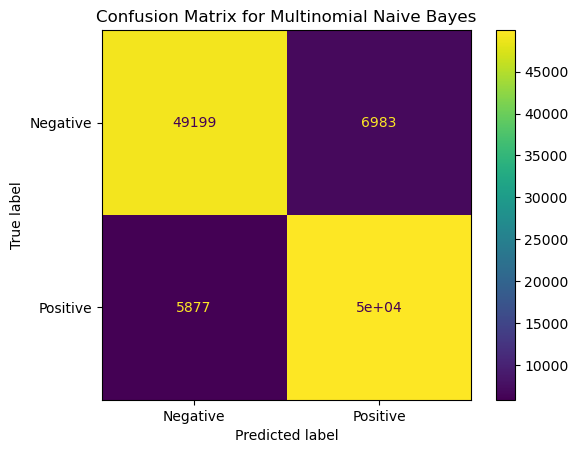

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_valid, model.predict(X_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"])
disp.plot()
plt.title("Confusion Matrix for Multinomial Naive Bayes")
plt.show()

In [51]:
log_red_grid.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 norm=None, use_idf=False)),
                ('lr',
                 LogisticRegression(max_iter=500, solver='newton-cholesky'))])

In [52]:
log_red_grid.best_params_

{'tfidf__use_idf': False,
 'tfidf__sublinear_tf': False,
 'tfidf__smooth_idf': True,
 'tfidf__norm': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__max_features': 5000,
 'lr__solver': 'newton-cholesky',
 'lr__penalty': 'l2',
 'lr__max_iter': 500}

In [53]:
model = log_red_grid.best_estimator_
print("Train Accuracy  : {:.2f} %".format(accuracy_score(model.predict(X_train), y_train)*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(model.predict(X_valid), y_valid)*100))
print("Precision       : {:.2f} %".format(precision_score(model.predict(X_valid), y_valid)*100))
print("Recall          : {:.2f} %".format(recall_score(model.predict(X_valid), y_valid)*100))

Train Accuracy  : 93.31 %
Test Accuracy   : 92.69 %
Precision       : 91.99 %
Recall          : 93.33 %


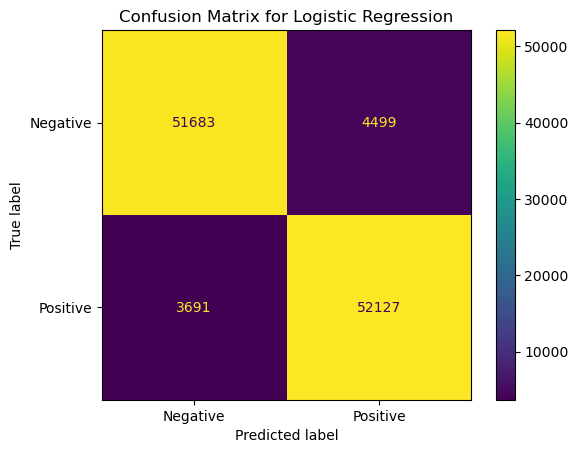

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_valid, model.predict(X_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"])
disp.plot()
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

In [55]:
dtree_grid.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 norm=None, smooth_idf=False,
                                 sublinear_tf=True)),
                ('dtree',
                 DecisionTreeClassifier(max_depth=70, min_samples_leaf=40))])

In [56]:
dtree_grid.best_params_

{'tfidf__use_idf': True,
 'tfidf__sublinear_tf': True,
 'tfidf__smooth_idf': False,
 'tfidf__norm': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__max_features': 5000,
 'dtree__min_samples_leaf': 40,
 'dtree__max_depth': 70,
 'dtree__criterion': 'gini'}

In [57]:
model = dtree_grid.best_estimator_
print("Train Accuracy  : {:.2f} %".format(accuracy_score(model.predict(X_train), y_train)*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(model.predict(X_valid), y_valid)*100))
print("Precision       : {:.2f} %".format(precision_score(model.predict(X_valid), y_valid)*100))
print("Recall          : {:.2f} %".format(recall_score(model.predict(X_valid), y_valid)*100))

Train Accuracy  : 83.72 %
Test Accuracy   : 81.99 %
Precision       : 82.64 %
Recall          : 81.68 %


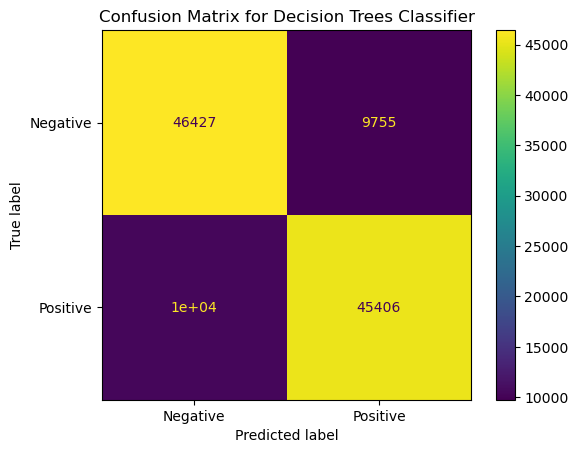

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_valid, model.predict(X_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"])
disp.plot()
plt.title("Confusion Matrix for Decision Trees Classifier")
plt.show()